# Computer Assignment 5 Phase 2 - Report
## Mahyar Karimi (810197690)
## Artificial Intelligence Course, University of Tehran
## Summer 2021

## Step 0. Before We Begin

The following library imports were necessary for our implementation of this task, as well as visualizing data and images:

In [1]:
from IPython.display import display
from tensorflow.keras import *
from tensorflow.keras.utils import *
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
import tensorboard
import os
from PIL import Image

In [ ]:
!cp drive/MyDrive/CA5P2/UTKFace.tar.gz .
!tar -xvf UTKFace.tar.gz
!rm UTKFace.tar.gz

## Step 1. Preprocessing and Data Visualization

In our first step, we need to extract our labels $(y_{\text{true}}$ for our future calculations) from filenames in our dataset; the following cell will do this task for us:

In [49]:
img_path, races = [], []
utk_path = '/content/UTKFace'

for img in os.listdir(utk_path):
    name_ext = img.split('.')
    if len(name_ext[0].split('_'))!= 4:
        continue
    img_path.append(os.path.join(utk_path, img))
    age, gender, race, datetime = name_ext[0].split('_')
    races.append(int(race))

We would then need to perform one-hot encoding on the currently ordinally encoded labels.

By using ordinary label encoding, we are creating an order in labels which might not exist otherwise; to solve this problem, we use one-hot encoding. If we have $n$ tasks, after one-hot encoding, we get an array with $n$ elements where each element represents a particular class; for each sample, all elements are equal to zero except the one which corresponds to the sample's label.

In [4]:
classes_labels = {0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Others'}
races = [to_categorical(i, len(classes_labels)) for i in races]

In [5]:
df = pd.DataFrame({'image': img_path, 'race': races})
display(df)

,image,race
0,/content/UTKFace/45_1_0_20170117135025030.jpg....,"[1.0, 0.0, 0.0, 0.0, 0.0]"
1,/content/UTKFace/40_1_0_20170104183430557.jpg....,"[1.0, 0.0, 0.0, 0.0, 0.0]"
2,/content/UTKFace/30_0_1_20170116010659651.jpg....,"[0.0, 1.0, 0.0, 0.0, 0.0]"
3,/content/UTKFace/22_0_0_20170117193856707.jpg....,"[1.0, 0.0, 0.0, 0.0, 0.0]"
4,/content/UTKFace/35_0_0_20170117193222963.jpg....,"[1.0, 0.0, 0.0, 0.0, 0.0]"
...,...,...
23700,/content/UTKFace/36_1_1_20170112233335504.jpg....,"[0.0, 1.0, 0.0, 0.0, 0.0]"
23701,/content/UTKFace/67_0_0_20170109002906472.jpg....,"[1.0, 0.0, 0.0, 0.0, 0.0]"
23702,/content/UTKFace/1_0_3_20161220143117879.jpg.c...,"[0.0, 0.0, 0.0, 1.0, 0.0]"
23703,/content/UTKFace/19_1_4_20170102235050099.jpg....,"[0.0, 0.0, 0.0, 0.0, 1.0]"


The following cell would count total number of data rows and count of each label (i.e. race) in our dataset:

Total image count: 23705
Count for each race: [10078.0, 4526.0, 3434.0, 3975.0, 1692.0]


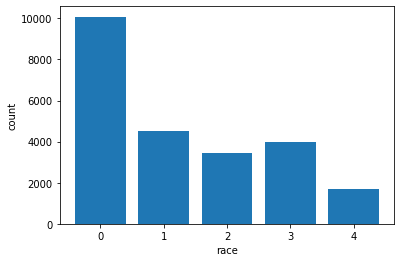

In [6]:
race_counts = list(df['race'].sum())
x = [0, 1, 2, 3, 4]

print('Total image count:', len(df))
print('Count for each race:', list(df['race'].sum()))
plt.bar(x, race_counts)
plt.xlabel('race')
plt.ylabel('count')
plt.show()

In the following cell, we select an image from each label; this step can also verify the correctness of our preprocessing.

,image,race
9892,/content/UTKFace/24_1_4_20170102233433610.jpg....,[0. 0. 0. 0. 1.]
15097,/content/UTKFace/55_0_3_20170117175457824.jpg....,[0. 0. 0. 1. 0.]
16077,/content/UTKFace/40_0_2_20170117001148193.jpg....,[0. 0. 1. 0. 0.]
4347,/content/UTKFace/21_1_1_20170116215704702.jpg....,[0. 1. 0. 0. 0.]
1232,/content/UTKFace/36_0_0_20170105170234235.jpg....,[1. 0. 0. 0. 0.]


Sample image for race=[0. 0. 0. 0. 1.]


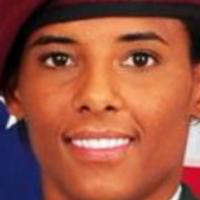

Sample image for race=[0. 0. 0. 1. 0.]


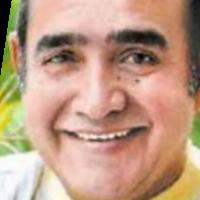

Sample image for race=[0. 0. 1. 0. 0.]


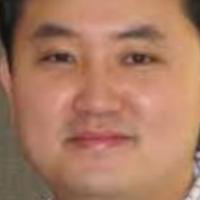

Sample image for race=[0. 1. 0. 0. 0.]


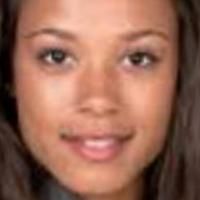

Sample image for race=[1. 0. 0. 0. 0.]


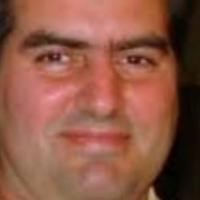

In [7]:
df = df.astype('str')
sample_df = df.groupby('race').sample(n=1, random_state=1)
display(sample_df)

for i in range(5):
    im = Image.open(sample_df.iloc[i]['image'])
    print('Sample image for race=' + sample_df.iloc[i]['race'])
    display(im)

We will take 70% of our data for training and 30% for testing, as suggested.

In [8]:
data_gen = preprocessing.image.ImageDataGenerator(rescale=1/255.0, validation_split=.3)

In [9]:
train_data = data_gen.flow_from_dataframe(dataframe=df, x_col='image', y_col='race', target_size= (100, 100), color_mode='grayscale',
                                          batch_size=32, classes_mode='categorical', subset='training', shuffle=False)

Found 16594 validated image filenames belonging to 5 classes.


In [10]:
test_data = data_gen.flow_from_dataframe(dataframe=df, x_col='image', y_col='race', target_size= (100, 100), color_mode='grayscale',
                                          batch_size=32, classes_mode='categorical', subset='validation', shuffle=False)

Found 7111 validated image filenames belonging to 5 classes.


## Step 2. First Try on Creating a Neural Network

In the following cells, we create our first network and train it using the training dataset we created before.

In [11]:
input = layers.Input(shape=(100, 100, 1))

output = layers.Flatten()(input)
output = layers.Dense(1024, activation='relu')(output)
output = layers.Dense(512, activation='relu')(output)
output = layers.Dense(5, activation='softmax')(output)

model = Model(inputs=input, outputs=output)

In [12]:
model.compile(optimizer=optimizers.SGD(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 1)]     0         
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              10241024  
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 2565      
Total params: 10,768,389
Trainable params: 10,768,389
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = model.fit(train_data, validation_data=test_data, epochs=10)

Epoch 1/10
519/519 [==============================] - 24s 41ms/step - loss: 1.2852 - accuracy: 0.5018 - val_loss: 1.2720 - val_accuracy: 0.4621
Epoch 2/10
519/519 [==============================] - 20s 39ms/step - loss: 1.1124 - accuracy: 0.5819 - val_loss: 0.9891 - val_accuracy: 0.6335
Epoch 3/10
519/519 [==============================] - 20s 39ms/step - loss: 1.0329 - accuracy: 0.6192 - val_loss: 0.9710 - val_accuracy: 0.6296
Epoch 4/10
519/519 [==============================] - 21s 40ms/step - loss: 0.9779 - accuracy: 0.6460 - val_loss: 1.0218 - val_accuracy: 0.6107
Epoch 5/10
519/519 [==============================] - 21s 40ms/step - loss: 0.9458 - accuracy: 0.6584 - val_loss: 0.8987 - val_accuracy: 0.6816
Epoch 6/10
519/519 [==============================] - 20s 39ms/step - loss: 0.9149 - accuracy: 0.6699 - val_loss: 0.8809 - val_accuracy: 0.6894
Epoch 7/10
519/519 [==============================] - 21s 41ms/step - loss: 0.8920 - accuracy: 0.6780 - val_loss: 0.8807 - val_accuracy:

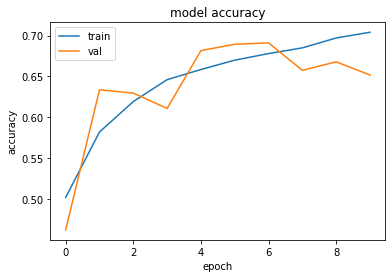

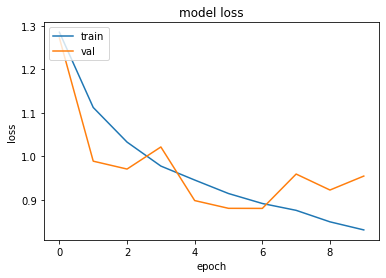

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [15]:
y_train = train_data.labels
y_pred = model.predict(train_data, batch_size=32, verbose=1)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_train, y_pred))

519/519 [==============================] - 14s 27ms/step
              precision    recall  f1-score   support

           0       0.44      0.03      0.05      1177
           1       0.81      0.36      0.50      2789
           2       0.91      0.40      0.55      2378
           3       0.58      0.91      0.71      3192
           4       0.67      0.88      0.76      7058

    accuracy                           0.67     16594
   macro avg       0.68      0.51      0.51     16594
weighted avg       0.69      0.67      0.63     16594



In [16]:
y_test = test_data.labels
y_pred = model.predict(test_data, batch_size=32, verbose=1)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred))

223/223 [==============================] - 6s 28ms/step
              precision    recall  f1-score   support

           0       0.35      0.02      0.04       515
           1       0.77      0.35      0.48      1186
           2       0.90      0.39      0.55      1056
           3       0.56      0.90      0.69      1334
           4       0.66      0.86      0.75      3020

    accuracy                           0.65      7111
   macro avg       0.65      0.50      0.50      7111
weighted avg       0.67      0.65      0.61      7111



## Step 3. Fine-Tuning our Model

In this step we are going to utilize some optimization techniques for improving performance of our neural network; it is worth note that not all these utilities are going to make a big difference on our result as our network is fairly simple and reaches an acceptable performance with our initial choice of activation functions.

## 3.1. Choosing the Optimizer

In our first step, we are going to increase the momentum parameter in our optimizer.

As we know, SGD runs on batches, and each batch would move weights towards a local minimum in its own region; therefore, our weights might not always move towards a point closer to the global minimum. Using a momentum factor will average our update values with previous values of weights, which results in a faster convergence. Increasing the value of momentum parameter might make our model to take bigger than necessary steps, so it might miss a local minimum.

We define a new sequence $V$ to implement momentum-aided SGD; update equation using momentum is redefined as follows:

$$V_t = \beta\,V_{t-1} + (1-\beta)\frac{\partial J}{\partial W}$$
$$W = W - \alpha\,V_t$$

In [17]:
input = layers.Input(shape=(100, 100, 1))

output = layers.Flatten()(input)
output = layers.Dense(1024, activation='relu')(output)
output = layers.Dense(512, activation='relu')(output)
output = layers.Dense(5, activation='softmax')(output)

model = Model(inputs=input, outputs=output)

In [18]:
model.compile(optimizer=optimizers.SGD(learning_rate=0.01, momentum=0.5), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 1)]     0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              10241024  
_________________________________________________________________
dense_4 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 2565      
Total params: 10,768,389
Trainable params: 10,768,389
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = model.fit(train_data, validation_data=test_data, epochs=10)

Epoch 1/10
519/519 [==============================] - 21s 40ms/step - loss: 1.2582 - accuracy: 0.5163 - val_loss: 1.1198 - val_accuracy: 0.5764
Epoch 2/10
519/519 [==============================] - 21s 40ms/step - loss: 1.0611 - accuracy: 0.6078 - val_loss: 1.0163 - val_accuracy: 0.5972
Epoch 3/10
519/519 [==============================] - 21s 40ms/step - loss: 0.9803 - accuracy: 0.6420 - val_loss: 0.8947 - val_accuracy: 0.6812
Epoch 4/10
519/519 [==============================] - 21s 40ms/step - loss: 0.9420 - accuracy: 0.6598 - val_loss: 0.8662 - val_accuracy: 0.6912
Epoch 5/10
519/519 [==============================] - 21s 41ms/step - loss: 0.9056 - accuracy: 0.6739 - val_loss: 0.9628 - val_accuracy: 0.6528
Epoch 6/10
519/519 [==============================] - 21s 41ms/step - loss: 0.8779 - accuracy: 0.6896 - val_loss: 0.9821 - val_accuracy: 0.6504
Epoch 7/10
519/519 [==============================] - 21s 41ms/step - loss: 0.8607 - accuracy: 0.6939 - val_loss: 0.8296 - val_accuracy:

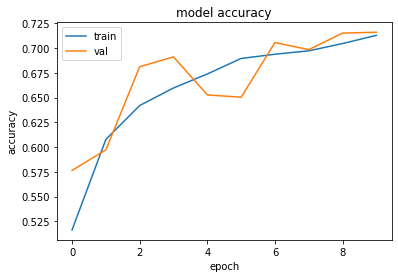

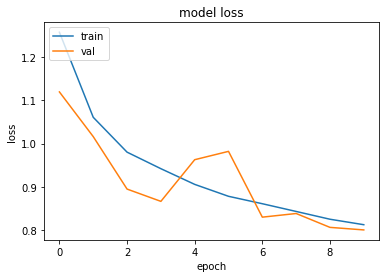

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [21]:
y_train = train_data.labels
y_pred = model.predict(train_data, batch_size=32, verbose=1)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_train, y_pred))

519/519 [==============================] - 14s 28ms/step
              precision    recall  f1-score   support

           0       0.50      0.01      0.02      1177
           1       0.67      0.65      0.66      2789
           2       0.78      0.70      0.73      2378
           3       0.88      0.74      0.80      3192
           4       0.71      0.91      0.80      7058

    accuracy                           0.74     16594
   macro avg       0.71      0.60      0.60     16594
weighted avg       0.73      0.74      0.71     16594



In [22]:
y_test = test_data.labels
y_pred = model.predict(test_data, batch_size=32, verbose=1)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred))

223/223 [==============================] - 6s 27ms/step
              precision    recall  f1-score   support

           0       0.50      0.01      0.02       515
           1       0.64      0.63      0.63      1186
           2       0.75      0.69      0.72      1056
           3       0.84      0.69      0.76      1334
           4       0.69      0.89      0.78      3020

    accuracy                           0.72      7111
   macro avg       0.69      0.58      0.58      7111
weighted avg       0.71      0.72      0.69      7111



In [23]:
input = layers.Input(shape=(100, 100, 1))

output = layers.Flatten()(input)
output = layers.Dense(1024, activation='relu')(output)
output = layers.Dense(512, activation='relu')(output)
output = layers.Dense(5, activation='softmax')(output)

model = Model(inputs=input, outputs=output)

In [24]:


model.compile(optimizer=optimizers.SGD(learning_rate=0.01, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100, 100, 1)]     0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              10241024  
_________________________________________________________________
dense_7 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 2565      
Total params: 10,768,389
Trainable params: 10,768,389
Non-trainable params: 0
_________________________________________________________________


In [25]:
history = model.fit(train_data, validation_data=test_data, epochs=10)

Epoch 1/10
519/519 [==============================] - 21s 41ms/step - loss: 1.2890 - accuracy: 0.5066 - val_loss: 1.1022 - val_accuracy: 0.6022
Epoch 2/10
519/519 [==============================] - 21s 41ms/step - loss: 1.1612 - accuracy: 0.5641 - val_loss: 1.1278 - val_accuracy: 0.5923
Epoch 3/10
519/519 [==============================] - 21s 41ms/step - loss: 1.1070 - accuracy: 0.5891 - val_loss: 1.0891 - val_accuracy: 0.5953
Epoch 4/10
519/519 [==============================] - 21s 40ms/step - loss: 1.0263 - accuracy: 0.6266 - val_loss: 0.9503 - val_accuracy: 0.6604
Epoch 5/10
519/519 [==============================] - 21s 40ms/step - loss: 0.9990 - accuracy: 0.6384 - val_loss: 1.0710 - val_accuracy: 0.6379
Epoch 6/10
519/519 [==============================] - 21s 41ms/step - loss: 0.9607 - accuracy: 0.6610 - val_loss: 0.9350 - val_accuracy: 0.6818
Epoch 7/10
519/519 [==============================] - 21s 40ms/step - loss: 0.9252 - accuracy: 0.6709 - val_loss: 0.9379 - val_accuracy:

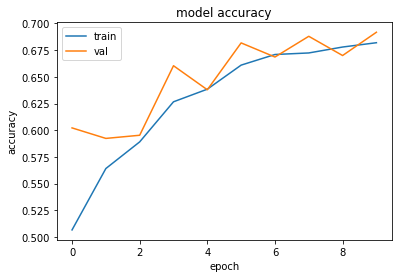

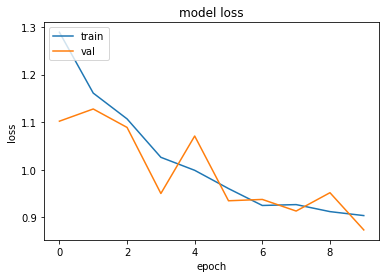

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [27]:
y_train = train_data.labels
y_pred = model.predict(train_data, batch_size=32, verbose=1)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_train, y_pred))

519/519 [==============================] - 14s 28ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1177
           1       0.53      0.75      0.62      2789
           2       0.72      0.74      0.73      2378
           3       0.91      0.58      0.71      3192
           4       0.73      0.84      0.78      7058

    accuracy                           0.70     16594
   macro avg       0.58      0.58      0.57     16594
weighted avg       0.68      0.70      0.68     16594



In [28]:
y_test = test_data.labels
y_pred = model.predict(test_data, batch_size=32, verbose=1)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred))

223/223 [==============================] - 6s 28ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       515
           1       0.52      0.75      0.62      1186
           2       0.72      0.74      0.73      1056
           3       0.89      0.58      0.70      1334
           4       0.72      0.82      0.77      3020

    accuracy                           0.69      7111
   macro avg       0.57      0.58      0.56      7111
weighted avg       0.67      0.69      0.67      7111



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Adam is a fairly new optimizer which exploits differents optimization methods for our ordinary SGD; we can observe how using this optimizer can help our model in learning faster.

In [29]:
input = layers.Input(shape=(100, 100, 1))

output = layers.Flatten()(input)
output = layers.Dense(1024, activation='relu')(output)
output = layers.Dense(512, activation='relu')(output)
output = layers.Dense(5, activation='softmax')(output)

model = Model(inputs=input, outputs=output)

In [30]:
model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100, 100, 1)]     0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              10241024  
_________________________________________________________________
dense_10 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 2565      
Total params: 10,768,389
Trainable params: 10,768,389
Non-trainable params: 0
_________________________________________________________________


In [31]:
history = model.fit(train_data, validation_data=test_data, epochs=10)

Epoch 1/10
519/519 [==============================] - 22s 41ms/step - loss: 1.5279 - accuracy: 0.5044 - val_loss: 1.0462 - val_accuracy: 0.6265
Epoch 2/10
519/519 [==============================] - 21s 41ms/step - loss: 1.0571 - accuracy: 0.6118 - val_loss: 0.9643 - val_accuracy: 0.6480
Epoch 3/10
519/519 [==============================] - 21s 41ms/step - loss: 0.9752 - accuracy: 0.6472 - val_loss: 1.1051 - val_accuracy: 0.6144
Epoch 4/10
519/519 [==============================] - 21s 41ms/step - loss: 0.9470 - accuracy: 0.6592 - val_loss: 0.9437 - val_accuracy: 0.6618
Epoch 5/10
519/519 [==============================] - 21s 41ms/step - loss: 0.9157 - accuracy: 0.6735 - val_loss: 0.9883 - val_accuracy: 0.6438
Epoch 6/10
519/519 [==============================] - 21s 40ms/step - loss: 0.8989 - accuracy: 0.6795 - val_loss: 0.8517 - val_accuracy: 0.7041
Epoch 7/10
519/519 [==============================] - 21s 40ms/step - loss: 0.8917 - accuracy: 0.6848 - val_loss: 0.8552 - val_accuracy:

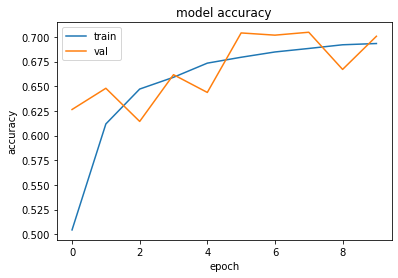

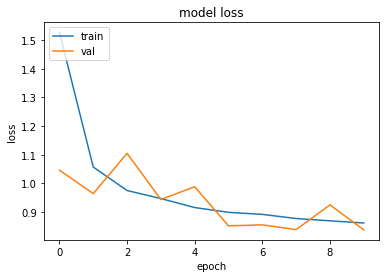

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [33]:
y_train = train_data.labels
y_pred = model.predict(train_data, batch_size=32, verbose=1)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_train, y_pred))

519/519 [==============================] - 14s 28ms/step
              precision    recall  f1-score   support

           0       0.27      0.04      0.07      1177
           1       0.65      0.60      0.63      2789
           2       0.85      0.57      0.68      2378
           3       0.84      0.73      0.78      3192
           4       0.68      0.91      0.78      7058

    accuracy                           0.71     16594
   macro avg       0.66      0.57      0.59     16594
weighted avg       0.70      0.71      0.69     16594



In [34]:
y_test = test_data.labels
y_pred = model.predict(test_data, batch_size=32, verbose=1)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred))

223/223 [==============================] - 6s 28ms/step
              precision    recall  f1-score   support

           0       0.29      0.04      0.07       515
           1       0.64      0.59      0.62      1186
           2       0.83      0.57      0.68      1056
           3       0.82      0.72      0.77      1334
           4       0.67      0.89      0.76      3020

    accuracy                           0.70      7111
   macro avg       0.65      0.56      0.58      7111
weighted avg       0.69      0.70      0.68      7111



## 3.2. Epochs

In the following cells, we train our model with Adam optimizer and we chose to keep it learning for 20 epochs.

As we know, SGD is an iterative algorithm and approaches the optimum through careful steps, which are our iterations; so we need to train our network in epochs in order to get the most from SGD; yet training our model for too many iterations can result in a more complex model which does not generalize well on test data (*aka* overfitting.)

In [58]:
input = layers.Input(shape=(100, 100, 1))

output = layers.Flatten()(input)
output = layers.Dense(1024, activation='relu')(output)
output = layers.Dense(512, activation='relu')(output)
output = layers.Dense(5, activation='softmax')(output)

model = Model(inputs=input, outputs=output)

In [59]:
model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 100, 100, 1)]     0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_27 (Dense)             (None, 1024)              10241024  
_________________________________________________________________
dense_28 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_29 (Dense)             (None, 5)                 2565      
Total params: 10,768,389
Trainable params: 10,768,389
Non-trainable params: 0
_________________________________________________________________


In [60]:
history = model.fit(train_data, validation_data=test_data, epochs=20)

Epoch 1/20
519/519 [==============================] - 21s 40ms/step - loss: 1.4775 - accuracy: 0.5080 - val_loss: 1.1062 - val_accuracy: 0.5906
Epoch 2/20
519/519 [==============================] - 20s 39ms/step - loss: 1.0557 - accuracy: 0.6129 - val_loss: 1.1571 - val_accuracy: 0.5458
Epoch 3/20
519/519 [==============================] - 20s 39ms/step - loss: 0.9724 - accuracy: 0.6501 - val_loss: 1.0532 - val_accuracy: 0.6124
Epoch 4/20
519/519 [==============================] - 21s 40ms/step - loss: 0.9421 - accuracy: 0.6612 - val_loss: 0.9376 - val_accuracy: 0.6642
Epoch 5/20
519/519 [==============================] - 20s 39ms/step - loss: 0.9211 - accuracy: 0.6671 - val_loss: 0.8833 - val_accuracy: 0.6924
Epoch 6/20
519/519 [==============================] - 21s 40ms/step - loss: 0.9011 - accuracy: 0.6775 - val_loss: 0.8830 - val_accuracy: 0.6867
Epoch 7/20
519/519 [==============================] - 21s 40ms/step - loss: 0.8804 - accuracy: 0.6899 - val_loss: 0.8419 - val_accuracy:

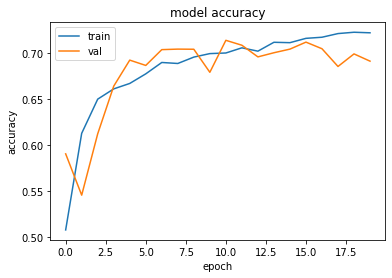

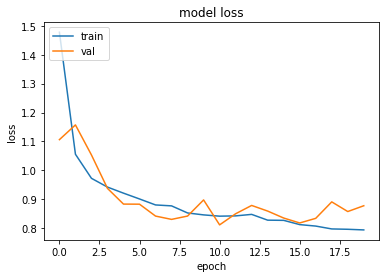

In [61]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [62]:
y_train = train_data.labels
y_pred = model.predict(train_data, batch_size=32, verbose=1)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_train, y_pred))

519/519 [==============================] - 14s 27ms/step
              precision    recall  f1-score   support

           0       0.31      0.03      0.05      1177
           1       0.58      0.71      0.64      2789
           2       0.66      0.82      0.73      2378
           3       0.93      0.55      0.69      3192
           4       0.74      0.86      0.79      7058

    accuracy                           0.71     16594
   macro avg       0.64      0.59      0.58     16594
weighted avg       0.71      0.71      0.69     16594



In [63]:
y_test = test_data.labels
y_pred = model.predict(test_data, batch_size=32, verbose=1)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred))

223/223 [==============================] - 6s 27ms/step
              precision    recall  f1-score   support

           0       0.21      0.02      0.04       515
           1       0.57      0.69      0.62      1186
           2       0.65      0.81      0.72      1056
           3       0.92      0.52      0.66      1334
           4       0.72      0.84      0.77      3020

    accuracy                           0.69      7111
   macro avg       0.61      0.58      0.56      7111
weighted avg       0.68      0.69      0.67      7111



## 3.3. Loss Function

In the following cells, we can see how using the MSE loss function is not the best choice for a classification problem.

MSE is usually used in regression problems, where our output has a continous domain and the notion of distance to the correct point ($|\hat{y}_i - y_i|$) can be well-defined; yet in classification problems, our final output will be a one-hot vector, and using MSE, loss value for each sample is always going to be either 0 or 2; therefore, MSE does not provide much information on how well our model has performed and how weights matrices need to be changed to improve its performance.

In [66]:
input = layers.Input(shape=(100, 100, 1))

output = layers.Flatten()(input)
output = layers.Dense(1024, activation='relu')(output)
output = layers.Dense(512, activation='relu')(output)
output = layers.Dense(5, activation='softmax')(output)

model = Model(inputs=input, outputs=output)

In [67]:
model.compile(optimizer=optimizers.Adam(), loss='mean_squared_error', metrics=['accuracy'])
model.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 100, 100, 1)]     0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_33 (Dense)             (None, 1024)              10241024  
_________________________________________________________________
dense_34 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_35 (Dense)             (None, 5)                 2565      
Total params: 10,768,389
Trainable params: 10,768,389
Non-trainable params: 0
_________________________________________________________________


In [68]:
history = model.fit(train_data, validation_data=test_data, epochs=10)

Epoch 1/10
519/519 [==============================] - 21s 40ms/step - loss: 0.3226 - accuracy: 0.1928 - val_loss: 0.3250 - val_accuracy: 0.1876
Epoch 2/10
519/519 [==============================] - 20s 39ms/step - loss: 0.3231 - accuracy: 0.1924 - val_loss: 0.3250 - val_accuracy: 0.1876
Epoch 3/10
519/519 [==============================] - 21s 40ms/step - loss: 0.3231 - accuracy: 0.1924 - val_loss: 0.3250 - val_accuracy: 0.1876
Epoch 4/10
519/519 [==============================] - 20s 39ms/step - loss: 0.3231 - accuracy: 0.1924 - val_loss: 0.3250 - val_accuracy: 0.1876
Epoch 5/10
519/519 [==============================] - 20s 39ms/step - loss: 0.3231 - accuracy: 0.1924 - val_loss: 0.3250 - val_accuracy: 0.1876
Epoch 6/10
519/519 [==============================] - 20s 39ms/step - loss: 0.3231 - accuracy: 0.1924 - val_loss: 0.3250 - val_accuracy: 0.1876
Epoch 7/10
519/519 [==============================] - 21s 40ms/step - loss: 0.3231 - accuracy: 0.1924 - val_loss: 0.3250 - val_accuracy:

In [69]:
y_train = train_data.labels
y_pred = model.predict(train_data, batch_size=32, verbose=1)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_train, y_pred))

519/519 [==============================] - 14s 27ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1177
           1       0.00      0.00      0.00      2789
           2       0.00      0.00      0.00      2378
           3       0.19      1.00      0.32      3192
           4       0.00      0.00      0.00      7058

    accuracy                           0.19     16594
   macro avg       0.04      0.20      0.06     16594
weighted avg       0.04      0.19      0.06     16594



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [70]:
y_test = test_data.labels
y_pred = model.predict(test_data, batch_size=32, verbose=1)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred))

223/223 [==============================] - 6s 27ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       515
           1       0.00      0.00      0.00      1186
           2       0.00      0.00      0.00      1056
           3       0.19      1.00      0.32      1334
           4       0.00      0.00      0.00      3020

    accuracy                           0.19      7111
   macro avg       0.04      0.20      0.06      7111
weighted avg       0.04      0.19      0.06      7111



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 3.4. Regularization and Dropout

As we know, overfitting is a an important issue in training neural networks; one method to avoid this problem is keeping our resulting hypothesis function simpler by keeping the weights smaller; this method is generally known as regularization and is achieved by adding a term to the cost function, which represents the value of our weights; therefore, greater values for weights result in greater penalties for our model. Using regularization might impact the performance of our model, yet it can help us in solving the problem of overfitting.

Another technique to solve the issue of overfitting is dynamically ignoring some nodes in our network by replacing their output with 0; this method can help our network to keep a dynamic state, resulting in a simpler hypothesis which generalizes better on test data.

In [52]:
input = layers.Input(shape=(100, 100, 1))

output = layers.Flatten()(input)
output = layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(output)
output = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(output)
output = layers.Dense(5, activation='softmax', kernel_regularizer=regularizers.l2(1e-4))(output)

model = Model(inputs=input, outputs=output)

In [53]:
model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 100, 100, 1)]     0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_24 (Dense)             (None, 1024)              10241024  
_________________________________________________________________
dense_25 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_26 (Dense)             (None, 5)                 2565      
Total params: 10,768,389
Trainable params: 10,768,389
Non-trainable params: 0
_________________________________________________________________


In [54]:
history = model.fit(train_data, validation_data=test_data, epochs=10)

Epoch 1/10
519/519 [==============================] - 22s 41ms/step - loss: 1.7154 - accuracy: 0.5169 - val_loss: 1.2582 - val_accuracy: 0.5922
Epoch 2/10
519/519 [==============================] - 21s 40ms/step - loss: 1.1913 - accuracy: 0.6054 - val_loss: 1.0599 - val_accuracy: 0.6472
Epoch 3/10
519/519 [==============================] - 21s 40ms/step - loss: 1.0670 - accuracy: 0.6472 - val_loss: 1.0236 - val_accuracy: 0.6493
Epoch 4/10
519/519 [==============================] - 21s 40ms/step - loss: 0.9983 - accuracy: 0.6641 - val_loss: 1.0553 - val_accuracy: 0.6369
Epoch 5/10
519/519 [==============================] - 21s 40ms/step - loss: 0.9675 - accuracy: 0.6731 - val_loss: 0.9527 - val_accuracy: 0.6833
Epoch 6/10
519/519 [==============================] - 21s 40ms/step - loss: 0.9485 - accuracy: 0.6735 - val_loss: 0.9871 - val_accuracy: 0.6615
Epoch 7/10
519/519 [==============================] - 21s 40ms/step - loss: 0.9222 - accuracy: 0.6872 - val_loss: 0.9073 - val_accuracy:

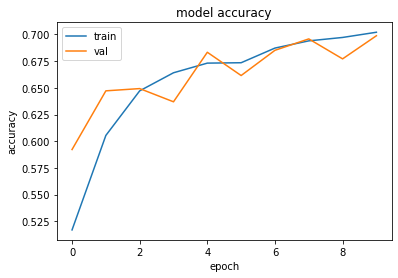

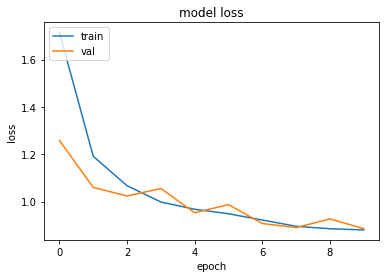

In [55]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [56]:
y_train = train_data.labels
y_pred = model.predict(train_data, batch_size=32, verbose=1)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_train, y_pred))

519/519 [==============================] - 14s 27ms/step
              precision    recall  f1-score   support

           0       0.33      0.00      0.01      1177
           1       0.63      0.60      0.61      2789
           2       0.65      0.79      0.72      2378
           3       0.88      0.66      0.76      3192
           4       0.70      0.86      0.77      7058

    accuracy                           0.71     16594
   macro avg       0.64      0.58      0.57     16594
weighted avg       0.69      0.71      0.68     16594



In [57]:
y_test = test_data.labels
y_pred = model.predict(test_data, batch_size=32, verbose=1)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred))

223/223 [==============================] - 6s 28ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       515
           1       0.62      0.59      0.61      1186
           2       0.65      0.79      0.72      1056
           3       0.87      0.65      0.74      1334
           4       0.69      0.85      0.76      3020

    accuracy                           0.70      7111
   macro avg       0.57      0.58      0.57      7111
weighted avg       0.66      0.70      0.67      7111



In [46]:
input = layers.Input(shape=(100, 100, 1))

output = layers.Flatten()(input)
output = layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(output)
output = layers.Dropout(1e-1)(output)
output = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(output)
output = layers.Dropout(1e-1)(output)
output = layers.Dense(5, activation='softmax', kernel_regularizer=regularizers.l2(1e-4))(output)
# output = layers.Dropout(1e-1)(output)

model = Model(inputs=input, outputs=output)

In [47]:
model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 100, 100, 1)]     0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_21 (Dense)             (None, 1024)              10241024  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 5)                 2565

In [48]:
history = model.fit(train_data, validation_data=test_data, epochs=10)

Epoch 1/10
519/519 [==============================] - 22s 40ms/step - loss: 1.7976 - accuracy: 0.4755 - val_loss: 1.3233 - val_accuracy: 0.5409
Epoch 2/10
519/519 [==============================] - 21s 40ms/step - loss: 1.2967 - accuracy: 0.5329 - val_loss: 1.1688 - val_accuracy: 0.5874
Epoch 3/10
519/519 [==============================] - 21s 40ms/step - loss: 1.2113 - accuracy: 0.5601 - val_loss: 1.1334 - val_accuracy: 0.6046
Epoch 4/10
519/519 [==============================] - 21s 41ms/step - loss: 1.1546 - accuracy: 0.5693 - val_loss: 1.0539 - val_accuracy: 0.6306
Epoch 5/10
519/519 [==============================] - 21s 40ms/step - loss: 1.1138 - accuracy: 0.5874 - val_loss: 0.9850 - val_accuracy: 0.6777
Epoch 6/10
519/519 [==============================] - 21s 40ms/step - loss: 1.0859 - accuracy: 0.5949 - val_loss: 0.9978 - val_accuracy: 0.6660
Epoch 7/10
519/519 [==============================] - 21s 40ms/step - loss: 1.0664 - accuracy: 0.6045 - val_loss: 1.0575 - val_accuracy:

In [50]:
y_train = train_data.labels
y_pred = model.predict(train_data, batch_size=32, verbose=1)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_train, y_pred))

519/519 [==============================] - 14s 27ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1177
           1       0.66      0.48      0.56      2789
           2       0.55      0.77      0.64      2378
           3       0.85      0.57      0.68      3192
           4       0.64      0.83      0.73      7058

    accuracy                           0.65     16594
   macro avg       0.54      0.53      0.52     16594
weighted avg       0.63      0.65      0.63     16594



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [51]:
y_test = test_data.labels
y_pred = model.predict(test_data, batch_size=32, verbose=1)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred))

223/223 [==============================] - 6s 27ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       515
           1       0.66      0.49      0.56      1186
           2       0.57      0.78      0.66      1056
           3       0.86      0.55      0.67      1334
           4       0.64      0.83      0.72      3020

    accuracy                           0.65      7111
   macro avg       0.54      0.53      0.52      7111
weighted avg       0.63      0.65      0.62      7111



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
